# Sparkify Music Streaming - Customer Churn Prediction Project
This is a Jupyter Notebook containing the code involving the dataset provided by Udacity.
Worked on IBM Cloud, with the full dataset (12 GB) uploaded to the IBM Cluster, for working with pyspark.

## Table of contents

## Problem Statement
The business goal of this project is to keep customers subscribed to the product (Sparkify). This specific dataset deals with data obtained from a hypothetical streaming service called Sparkify, similar to Spotify, made for Big Data Analysis using Apache Spark. Specifically, this project is a Customer Churn Predictive Modeling - one of the most prevalent business and product problems in Data Science.

### The Question and approach
* Given a user's behavior on Sparkify, how likely are they to churn (to cancel their subscription)?
* The question is solved through a Machine Learning approach, particularly, a classification approach.
The project explores different types of classification algorithms to support the argument that there is a strong partial correlation between the user's behavior and their likelihood to churn.
The algorithms trained and tested are: Random Forest Classifier, Logistic Regression, Gradient Boosting Trees Classifier and the Linear Support Vector Classifier.
Inspired from Apache Spark ML documentation
The models are further tuned for its hyperparameters, to improve their performances, and the algorithms are evaluated based on the F1-Score.

#### It is important to note that the Accuracy Score is used just for a comparison. The main metric based on which the model is picked is the F1-Score.

#### F1-Score
The Accuracy Score gives more importance to the True Positives and the True Negatives. This is good in cases of a balanced classification problem. The F1-Score on the other hand, by its very definition, gives more importance to False Positives and False Negatives, and a higher F1-Score means better performance by the model.
In real world classification problems, especially for customer churn problems, the data is almost always unbalanced (simply because if the cutomer churn rate is 50%, the business model is too bad to analyze in first place).

Additionally, Grid Search and Cross Validation are used to tune the hyperparameters to obtain an optimal understanding of the interactions between the features and the target variable.

## Preprocessing data
### Loading data

In [1]:
import ibmos2spark, os
# @hidden_cell

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_2efd01da3ff54fdaa3470f598c7e28fc = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_2efd01da3ff54fdaa3470f598c7e28fc = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

credentials = {
    'endpoint': endpoint_2efd01da3ff54fdaa3470f598c7e28fc,
    'service_id': 'iam-ServiceId-df23bbb4-9672-4192-82a0-7008d363442d',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'egtJ8GoW6t2ZOLybrK0J48NEMWAyDY5n4BCXMJudoW0c'
}

configuration_name = 'os_2efd01da3ff54fdaa3470f598c7e28fc_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-8lpkzpejulf8uc'))
df.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210810174127-0000
KERNEL_ID = 5325527c-c42f-42cf-8acb-93cedd627eee


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [2]:
# Installing the Spark llibraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

# Installing Spark ML libraries
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Installing python libraries
import re
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

In [4]:
# the schema of the Spark DataFrame
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Raw data columns
* artist - the artist of the soundtrack
* auth - variable indicating whether the user has cancelled the subscription or not
* firstName - first name of the user
* gender - gender of the user
* ItemInSession - Item ID for each session (row) recorded
* lastName - last name of the user
* length - length of each session by the user
* level - the level of subscription of the user (free trial or paid)
* location - location data of the user (city and state)
* page - the page in Sparkify the user visited in each session
* song - the song listened to in each session, by the user
* ts - the timestamp of each session
* userAgent - the user agent used by the user to visit sparkify
* userId - unique number identifying each user

In [5]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            543705|
|   mean| 60268.42669103512|
| stddev|109898.82324176628|
|    min|                  |
|    max|                99|
+-------+------------------+



In [6]:
df.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            543705|
|   mean|2040.8143533717732|
| stddev| 1434.338931078271|
|    min|                 1|
|    max|              4808|
+-------+------------------+



In [7]:
df.select('status').take(2)

[Row(status=200), Row(status=200)]

In [8]:
df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [9]:
df.count()

543705

In [10]:
df.filter(isnull(df['userId'])).count()

0

In [11]:
df.filter(isnull(df['sessionId'])).count()

0

In [12]:
df.filter(df['userId']=='').count()

15700

In [13]:
df_new = df.filter(df['userId'] != '')

In [14]:
# Convert timestamp format to a recognizable datetime format
ts_todate = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

df_new = df_new.withColumn('datetime', ts_todate(df_new.ts))

In [15]:
df_new.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', datetime='2018-10-01 00:00:11'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98', datetime='2018-10-01 00:00:25'),
 Row(artist

In [16]:
df_new.createOrReplaceTempView('Sparkify_local_tinkered')

## EDA (Exploratory Data Analysis)

This section of the notebook contains EDA for the dataset, exploring all the features in detail, along with cleaning some of the variables and extracting more features, etc. in order to move on to the feature engineering part of the notebook, which will contain the features selected based on the analyses conducted in this section.

#### Below we use spark sql for EDA

In [17]:
# Command to identify the unique values under the variable `auth`
spark.sql('''
          SELECT DISTINCT(auth)
          FROM Sparkify_local_tinkered
            
            ''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [18]:
# Command to find out the number of unique users
spark.sql('''
        SELECT count(DISTINCT userId) as Unique_Users
        FROM Sparkify_local_tinkered
''').show()

+------------+
|Unique_Users|
+------------+
|         448|
+------------+



In [19]:
# How many users among the total unique users have cancelled a subscription? Either from paid to free, or free to cancelled.
spark.sql('''
        SELECT auth, count(DISTINCT userID) as count_users
        FROM Sparkify_local_tinkered
        GROUP BY auth
        ORDER BY count_users DESC
''').show()

+---------+-----------+
|     auth|count_users|
+---------+-----------+
|Logged In|        448|
|Cancelled|         99|
+---------+-----------+



In [20]:
# Command to find out the gender division of the dataset's unique users.
gender_division = spark.sql('''
        SELECT gender, count(DISTINCT userID) as count_users
        FROM Sparkify_local_tinkered
        GROUP BY gender
        ORDER BY count_users DESC
''')
gender_division.show()


+------+-----------+
|gender|count_users|
+------+-----------+
|     M|        250|
|     F|        198|
+------+-----------+



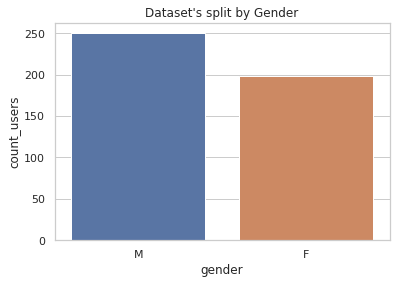

In [21]:
sns.set(style='whitegrid')
sns.barplot(x = 'gender', y = 'count_users', data = gender_division.toPandas());
plt.title("Dataset's split by Gender");

In [22]:
spark.sql('''
        SELECT count(DISTINCT itemInSession) as count_items
        FROM Sparkify_local_tinkered
                                    ''').show()

+-----------+
|count_items|
+-----------+
|       1006|
+-----------+



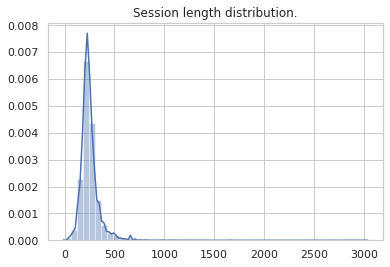

In [23]:
length_session = spark.sql('''
                        SELECT length
                        FROM Sparkify_local_tinkered
                                                    ''')
sns.distplot(length_session.toPandas().dropna());
plt.title('Session length distribution.');

In [24]:
# Command to find out the status of the user's subsciptions, encoded in the variable `level`
spark.sql('''
        SELECT level, count(DISTINCT userId) as count_users
        FROM Sparkify_local_tinkered
        GROUP BY level
        ORDER BY count_users DESC
        ''').show()

+-----+-----------+
|level|count_users|
+-----+-----------+
| free|        370|
| paid|        321|
+-----+-----------+



In [25]:
print(f'{(370 + 321) - 448} ' + 'users have changed their level.')

243 users have changed their level.


In [26]:
# Command to retrieve the location data of the users
location_data = spark.sql('''
                        SELECT location, count(DISTINCT userId) as count_users
                        FROM Sparkify_local_tinkered
                        GROUP BY location
                        ORDER BY count_users DESC
                        ''').toPandas()

In [27]:
location_data

,location,count_users
0,"Los Angeles-Long Beach-Anaheim, CA",30
1,"New York-Newark-Jersey City, NY-NJ-PA",30
2,"Chicago-Naperville-Elgin, IL-IN-WI",19
3,"San Francisco-Oakland-Hayward, CA",10
4,"Miami-Fort Lauderdale-West Palm Beach, FL",9
...,...,...
187,"Worcester, MA-CT",1
188,"Jacksonville, FL",1
189,"Lafayette, LA",1
190,"Brunswick, GA",1


In [28]:
# Separating states from cities
location_data = location_data.join(location_data['location'].str.split(',', expand = True).\
                                   rename(columns = {0: 'city', 1: 'state'})).drop('location', 1)
location_data.head(5)

,count_users,city,state
0,30,Los Angeles-Long Beach-Anaheim,CA
1,30,New York-Newark-Jersey City,NY-NJ-PA
2,19,Chicago-Naperville-Elgin,IL-IN-WI
3,10,San Francisco-Oakland-Hayward,CA
4,9,Miami-Fort Lauderdale-West Palm Beach,FL


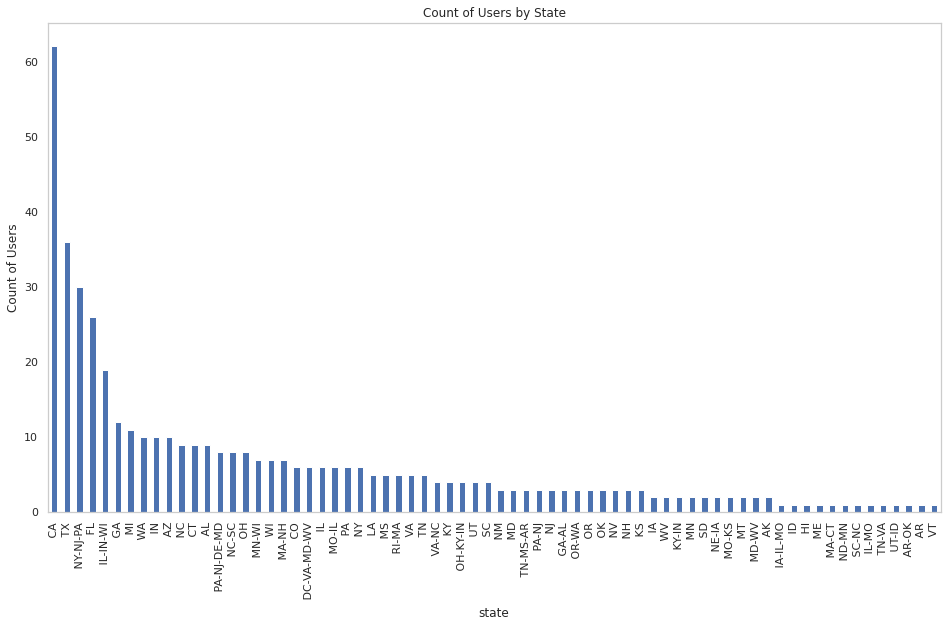

In [29]:
# Plotting users by state
location_data.groupby('state')['count_users'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(16,9));
plt.grid(False)
plt.ylabel('Count of Users')
plt.title('Count of Users by State');

#### Above distribution makes sense as CA, TX and tristate area have the highest population.

In [30]:
# Command to find out which pages have been visited the most by the users
page_visits = spark.sql('''
                        SELECT page, count(userId) as count_users
                        FROM Sparkify_local_tinkered
                        GROUP BY page
                        ORDER BY count_users
                        ''').toPandas()

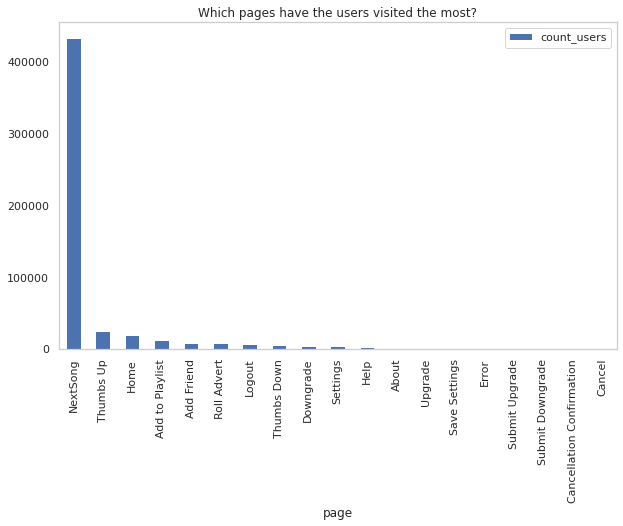

In [31]:
# Pandas DataFrame manipulations to obtain a sorted page visit dataset.
page_visits.sort_values(by='count_users', ascending=False, inplace=True)
page_visits.set_index('page', inplace=True)
page_visits.plot(kind='bar', figsize=(10,6))
plt.grid(False)
plt.title('Which pages have the users visited the most?');

The above looks good as next song does seem like the page which users would use the most

In [32]:
# the user agent variable defines the mode by which the users viewed the product - browser and platforms.
user_agents = spark.sql('''
                        SELECT userAgent, count(DISTINCT userId) as count_users
                        FROM Sparkify_local_tinkered
                        GROUP BY userAgent
                        ORDER BY count_users DESC
                        ''').toPandas()

In [33]:
user_agents['userAgent'].nunique()

71

In [34]:
user_agents.head(5)

,userAgent,count_users
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39
1,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,34
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",30
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",25
4,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",22


In [35]:
def get_browser(x):
    '''
    INPUT: x --> a DataFrame's series containing different text values
    of the user agent information.
    
    DESCRIPTION: This functions extracts different agents' name from a complicated
    string of raw user agent data.
    '''
    
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [36]:
# Applying this function to the dataframe sliced from the main dataframe.
user_agents['browser'] = user_agents['userAgent'].apply(get_browser)

In [37]:

# The lack of a np.nan shows that there were no other browser other than the 4 suggested.
user_agents['browser'].unique()

array(['Chrome', 'Firefox', 'Safari', 'IE'], dtype=object)

In [38]:
# Classification of the platform (OS) and applying regex to extract the useful information.
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}
user_agents['platform'] = user_agents['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)
user_agents.drop('userAgent', 1, inplace=True)

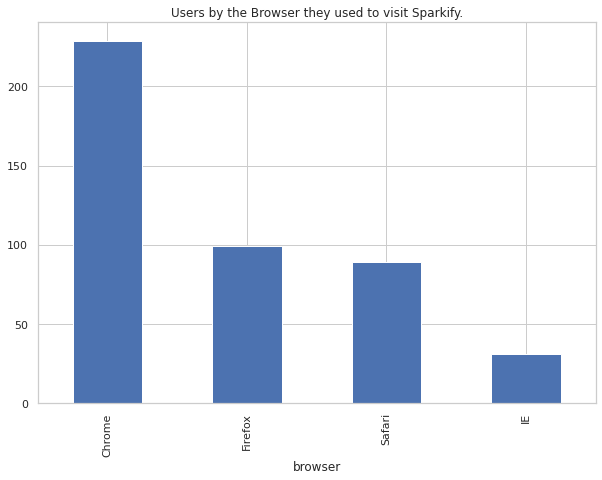

In [39]:

user_agents.groupby('browser').sum()['count_users'].sort_values(ascending=False).plot(kind='bar', figsize=(10,7));
plt.title('Users by the Browser they used to visit Sparkify.');

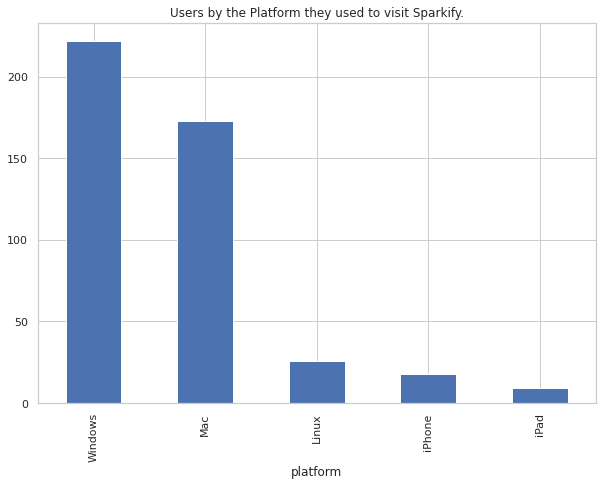

In [40]:
user_agents.groupby('platform').sum()['count_users'].sort_values(ascending=False).plot(kind='bar', figsize=(10,7));
plt.title('Users by the Platform they used to visit Sparkify.');

#### Both the above graphs make sense as chrome and windows are indeed widely used.

In [41]:
time_data = spark.sql('''
                    SELECT datetime, userId
                    FROM Sparkify_local_tinkered
                    ORDER BY datetime
                        ''').toPandas()
time_data

,datetime,userId
0,2018-10-01 00:00:11,293
1,2018-10-01 00:00:25,98
2,2018-10-01 00:01:58,179
3,2018-10-01 00:01:59,179
4,2018-10-01 00:02:04,246
...,...,...
528000,2018-11-30 23:59:53,163
528001,2018-12-01 00:00:01,300015
528002,2018-12-01 00:00:04,163
528003,2018-12-01 00:00:05,100008


In [42]:
# looking at the when the users login for a session
time_data['datetime'] = pd.to_datetime(time_data['datetime'], format='%Y-%m-%d %H:%M:%S')
weekday_decoded = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
time_data['weekday'] = time_data['datetime'].dt.weekday.map(weekday_decoded)
time_data['day'] = time_data['datetime'].dt.day
time_data['hour'] = time_data['datetime'].dt.hour
time_data.tail(10)

,datetime,userId,weekday,day,hour
527995,2018-11-30 23:59:36,27,Friday,30,23
527996,2018-11-30 23:59:38,86,Friday,30,23
527997,2018-11-30 23:59:39,153,Friday,30,23
527998,2018-11-30 23:59:39,46,Friday,30,23
527999,2018-11-30 23:59:52,300038,Friday,30,23
528000,2018-11-30 23:59:53,163,Friday,30,23
528001,2018-12-01 00:00:01,300015,Saturday,1,0
528002,2018-12-01 00:00:04,163,Saturday,1,0
528003,2018-12-01 00:00:05,100008,Saturday,1,0
528004,2018-12-01 00:01:06,200030,Saturday,1,0


In [43]:
time_grouped = time_data.groupby('weekday')['userId'].count()

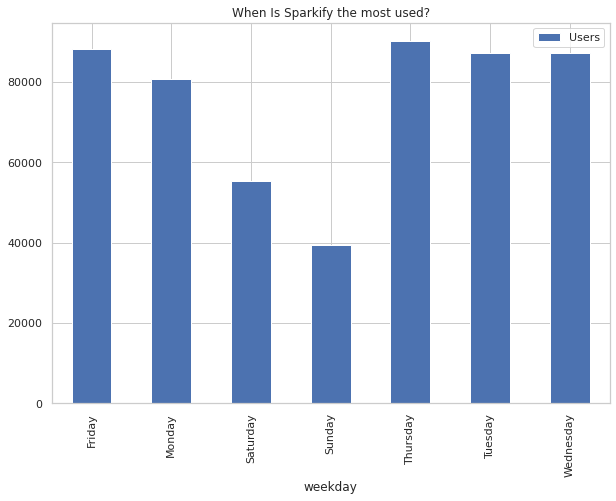

In [44]:
time_grouped = pd.DataFrame(time_grouped)
time_grouped.rename(columns={'userId':'Users'}, inplace=True)
time_grouped.plot(kind='bar', figsize=(10,7));
plt.title('When Is Sparkify the most used?');

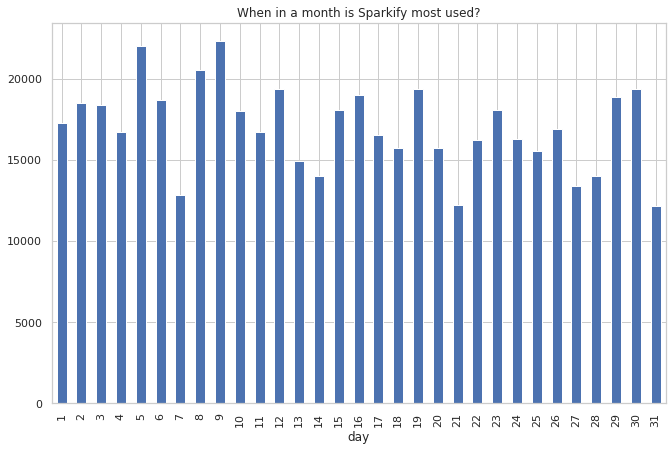

In [45]:
time_data.groupby('day').count()['userId'].plot(kind='bar', figsize=(11,7));
plt.title('When in a month is Sparkify most used?');

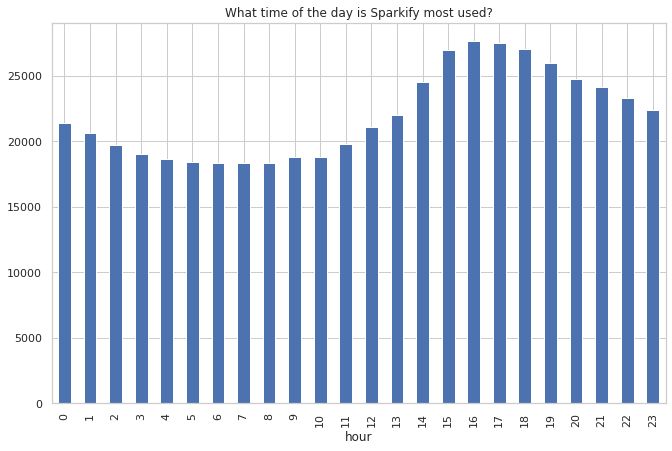

In [46]:
time_data.groupby('hour').count()['userId'].plot(kind='bar', figsize=(11,7));
plt.title('What time of the day is Sparkify most used?');

In [47]:
df_new.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

### Defining the Target Variable - Churn
This project uses the cancellation confirmation in the pages variable, to flag that the user has churned. This variable includes not just cancelling, but also downgrading. Perhaps the question will change if only the downgrading was recorded. But this project uses the Cancellation Confirmation as the indicator of Churn, and a binary variable is derived from this flagged event. The code below follows this to obtain the Churn column.

In [48]:
flag_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [49]:
df_new_churn = df_new.withColumn('Churned', flag_event('page'))

In [50]:
windows = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_new_churn = df_new_churn.withColumn('Churn', fmax('Churned').over(windows))

In [51]:
df_new_churn.take(1)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 09:36:32', Churned=0, Churn=1)]

In [52]:
df_new_churn.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=99), Row(Churn=0, count=349)]

In [53]:
df_new_churn.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  349|
|    1|Logged In|   99|
+-----+---------+-----+



In [54]:
df_new_churn.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|  196|
|    0|     F|  153|
|    1|     F|   45|
|    1|     M|   54|
+-----+------+-----+



In [55]:

# A two sample Z-Test is used to determine the difference in the mean Churn based on Gender is present.
proportions_ztest([54,45],[(250), (198)],alternative='two-sided')

(-0.28558822400048295, 0.7751935238693246)

This shows that gender does not play a role in churn.

In [56]:
# Obtaining the mean, stddev, min and max of the length of each session, grouped by user.
df_new_churn.select(['Churn', 'length']).groupby('Churn').agg(avg('length').alias('mean_length'), 
                                                             stddev('length').alias('stddev_length'),
                                                             fmin('length').alias('minimum_length'),
                                                             fmax('length').alias('maximum_length')).show()

+-----+------------------+-----------------+--------------+--------------+
|Churn|       mean_length|    stddev_length|minimum_length|maximum_length|
+-----+------------------+-----------------+--------------+--------------+
|    1|248.99398360601683|98.49278064882213|       4.04853|    2594.87302|
|    0| 248.5848635245237|98.39324443629276|       0.78322|    3024.66567|
+-----+------------------+-----------------+--------------+--------------+



In [57]:
df_new_churn.take(1)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 09:36:32', Churned=0, Churn=1)]

In [58]:
df_new_churn.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  244|
|    0| paid|  105|
|    1| paid|   32|
|    1| free|   67|
+-----+-----+-----+



In [59]:
# Z-test to see if the level the user is on, has an impact on Churn
proportions_ztest([33, 66], [130, 318], alternative='two-sided')

(1.0719274524808762, 0.2837526186143944)

The level of the user does not have an impact on the Churn

In [60]:
def get_grouped_data(data):
    '''
    INPUT: data --> dataframe or series
    
    DESCRIPTION: This function gives a normalized value for whether
    the user churned or not, based on MinMax Scaling. This is then
    used to visualize the churn behaviour based on each categorical class.
    '''
    grouped_series = data.set_index(list(data.columns[:2]))
#     print(grouped_series.head(),grouped_series.index)
    temp = grouped_series.unstack('Churn').fillna(0)
#     print(temp.head())
    df = pd.DataFrame((temp - temp.min()) / (temp.max() - temp.min())).stack().reset_index()
#     print(df.head())
    df.rename(columns={df.columns[-1]: 'results'}, inplace=True)
    return df

In [61]:
split_city_state = split(df_new_churn['location'], ',')
df_new_churn = df_new_churn.withColumn('city',split_city_state.getItem(0))
df_new_churn = df_new_churn.withColumn('state',split_city_state.getItem(1))

In [62]:
cities_df = df_new_churn.dropDuplicates(['userId']).groupBy(['city', 'Churn']).count().sort('Churn').toPandas()

In [63]:
cities_df = get_grouped_data(cities_df)
cities_df

,city,Churn,results
0,Akron,0,0.000000
1,Akron,1,0.125000
2,Albany,0,0.000000
3,Albany,1,0.125000
4,Albany-Schenectady-Troy,0,0.043478
...,...,...,...
369,Winston-Salem,1,0.125000
370,Worcester,0,0.043478
371,Worcester,1,0.000000
372,York-Hanover,0,0.043478


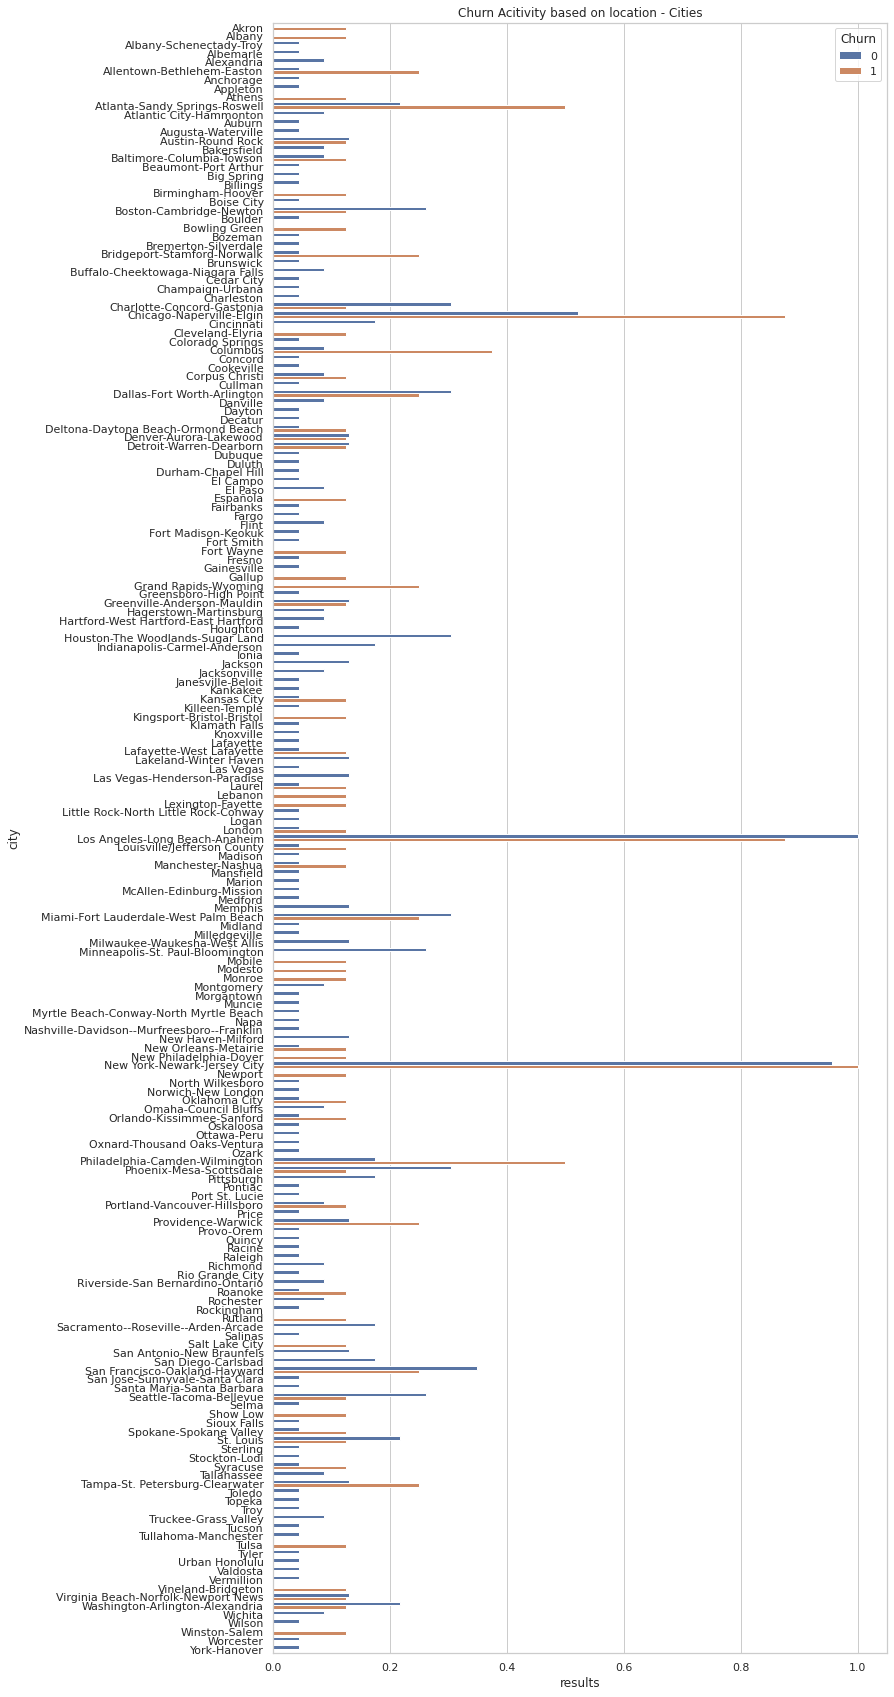

In [64]:
fig, ax = plt.subplots(figsize = (11, 30))
sns.barplot(x = 'results', y = 'city', hue = 'Churn', data = cities_df, ax = ax);
plt.title('Churn Acitivity based on location - Cities');

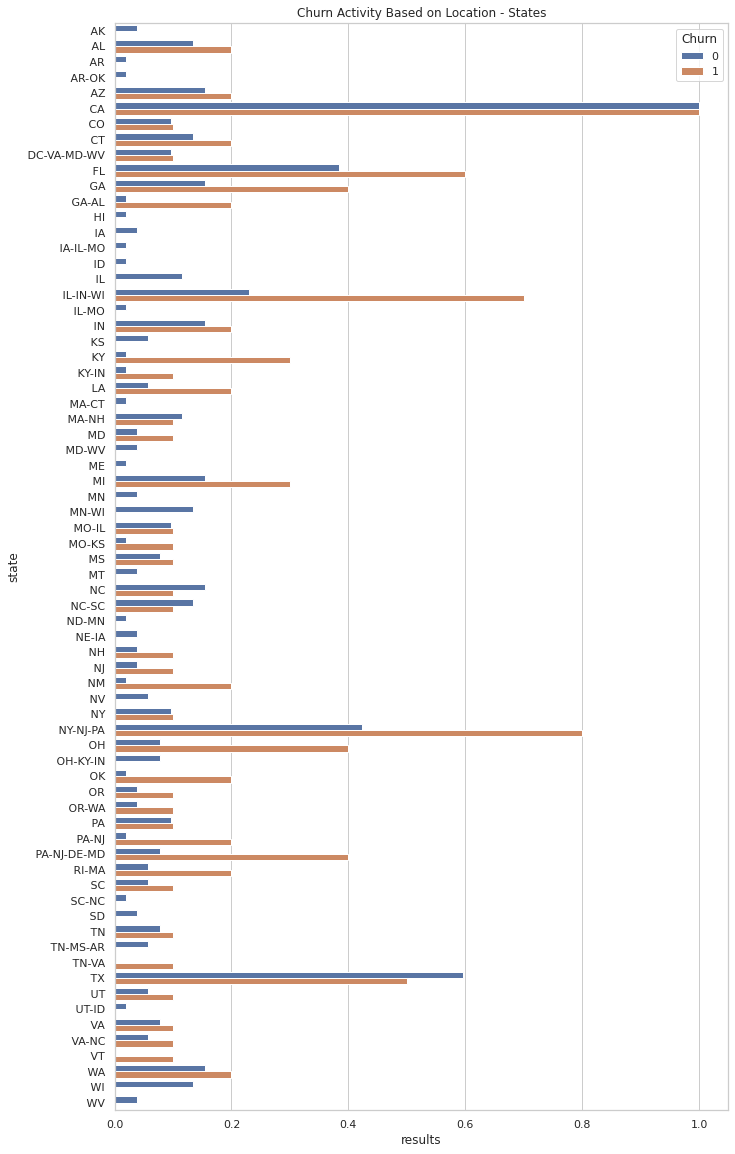

In [65]:
states_df = df_new_churn.dropDuplicates(["userId"]).groupby(["state","Churn"]).count().sort("state").toPandas()
states_df = get_grouped_data(states_df)
fig, ax = plt.subplots(figsize = (11, 20))
sns.barplot(x = 'results', y = 'state', hue = 'Churn', data = states_df, ax = ax);
plt.title('Churn Activity Based on Location - States');

In [66]:
# churn behaviour based on the pages visited (count)
df_new_churn.select(["Churn", "page"]).groupby(["Churn", "page"]).count().sort("page").show()

+-----+--------------------+------+
|Churn|                page| count|
+-----+--------------------+------+
|    1|               About|   185|
|    0|               About|   841|
|    0|          Add Friend|  6550|
|    1|          Add Friend|  1537|
|    1|     Add to Playlist|  2259|
|    0|     Add to Playlist| 10090|
|    1|              Cancel|    99|
|    1|Cancellation Conf...|    99|
|    0|           Downgrade|  2980|
|    1|           Downgrade|   831|
|    0|               Error|   406|
|    1|               Error|    97|
|    0|                Help|  2127|
|    1|                Help|   517|
|    1|                Home|  3778|
|    0|                Home| 15311|
|    1|              Logout|  1184|
|    0|              Logout|  4806|
|    1|            NextSong| 84359|
|    0|            NextSong|348518|
+-----+--------------------+------+
only showing top 20 rows



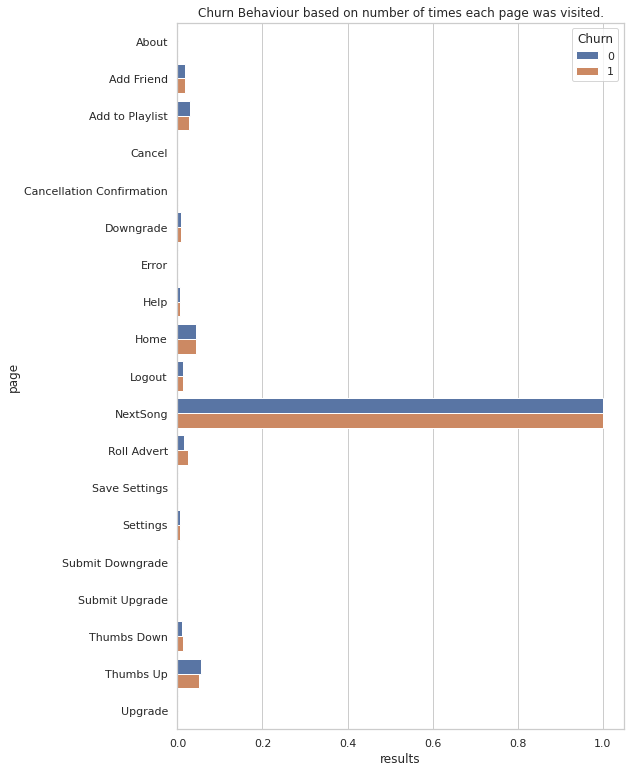

In [67]:
page_df = df_new_churn.select(['page', 'Churn']).groupBy(['page', 'Churn']).count().sort('page').toPandas()
page_df = get_grouped_data(page_df)
fig, ax = plt.subplots(figsize = (8, 13))
sns.barplot(x = 'results', y = 'page', hue = 'Churn', data = page_df, ax = ax);
plt.title('Churn Behaviour based on number of times each page was visited.');


In [68]:
browsers = udf(lambda x: get_browser(x))

In [69]:
df_new_churn = df_new_churn.withColumn('browser', browsers(df_new_churn.userAgent))

In [70]:
# Functions to get the values for the browsers and the platforms used.
get_platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])
df_new_churn = df_new_churn.withColumn('platform',get_platform(df_new_churn.userAgent))

In [71]:
browsers_df = df_new_churn.select(["browser","Churn"]).groupby([ "browser","Churn"]).count().sort("browser").toPandas()

In [72]:
browsers_df = get_grouped_data(browsers_df)

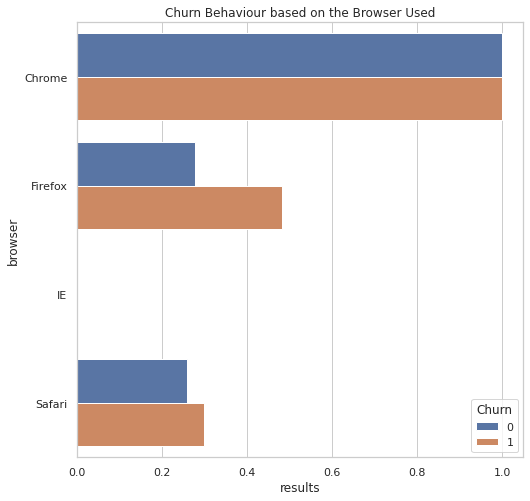

In [73]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.barplot(x = 'results', y = 'browser', hue = 'Churn', data = browsers_df, ax = ax);
plt.title('Churn Behaviour based on the Browser Used');

In [74]:
platform_df = df_new_churn.select(["platform","Churn"]).groupby([ "platform","Churn"]).count().sort("platform").toPandas()

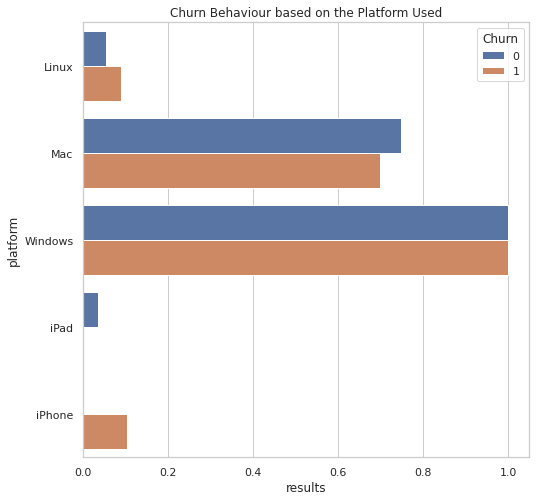

In [75]:
platform_df = get_grouped_data(platform_df)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x="results", y="platform", hue="Churn", data=platform_df, ax=ax);
plt.title('Churn Behaviour based on the Platform Used');

In [76]:
# The following cells are to extract hour, day and weekday from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%w'))

# Making new columns to input the time variables.
df_new_churn = df_new_churn.withColumn('hour', get_hour(df_new_churn.ts))
df_new_churn = df_new_churn.withColumn('day', get_day(df_new_churn.ts))
df_new_churn = df_new_churn.withColumn('weekday', get_weekday(df_new_churn.ts))

In [77]:
hour_df = df_new_churn.select(["Churn", "hour"]).groupby(["Churn", "hour"]).count().sort("hour").toPandas()
day_df = df_new_churn.select(["Churn", "day"]).groupby(["Churn", "day"]).count().sort("day").toPandas()
weekday_df = df_new_churn.select(["Churn", "weekday"]).groupby(["Churn", "weekday"]).count().sort("weekday").toPandas()

In [78]:
hour_df = get_grouped_data(hour_df)
day_df = get_grouped_data(day_df)
weekday_df = get_grouped_data(weekday_df)

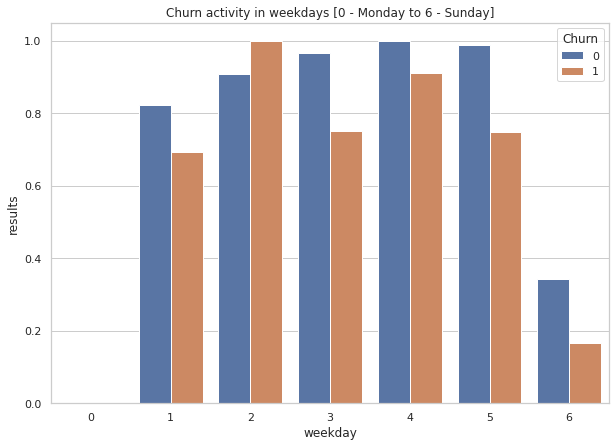

In [79]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x = 'weekday', y = 'results', data = weekday_df, hue = 'Churn', ax = ax);
plt.title('Churn activity in weekdays [0 - Monday to 6 - Sunday]');

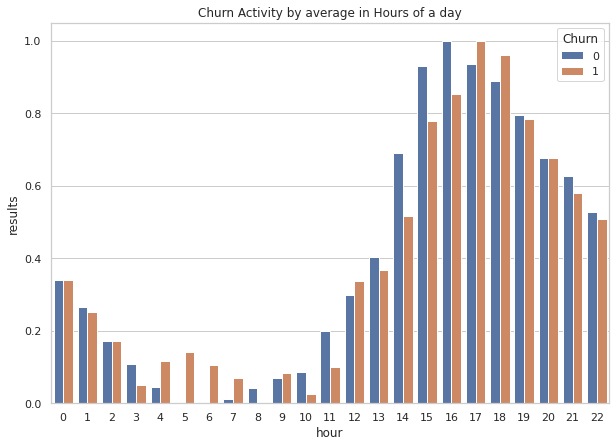

In [80]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.barplot(x = 'hour', y = 'results', hue = 'Churn', data = hour_df, ax = ax, order = list(map(lambda x: str(x), range(23))));
plt.title('Churn Activity by average in Hours of a day');

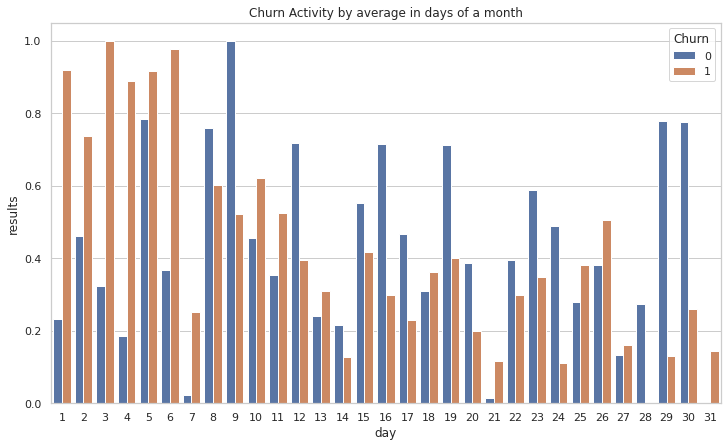

In [81]:
fig, ax = plt.subplots(figsize = (12,7))
sns.barplot(x = 'day', y = 'results', hue = 'Churn', data = day_df, ax = ax, order = list(map(lambda x: str(x), range(1, 32))))
plt.title('Churn Activity by average in days of a month');

In [82]:
df_new_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- Churned: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- hour: string (nullable = true)


## Feature Engineering
Based on the Exploratory Data Analysis above, the features picked and used for modelling are defined below, along with the motivation for each feature.

### The categorical variables
* Gender - Label encoding gender, making a 0 and 1 for two unique values, identifying the user appropriately.
* Level - Similarly, for two different levels, the variables are label-encoded.
* browser - the 4 different browsers used are encoded from 0 to 3.
* platform - the different platforms used by users to view Sparkify is label encoded.
### The numerical variables
* Length - The average length, standard deviation of the average length, minimum and maximum values of length for each user is taken. Churning customers are typically expected to spend less time on general operations in the application, given a long enough time period.
* Page - Based on the activity by users in different pages, pages most visited are taken, aggregated by count. A churning customer would for example visit the Thumbs Down, Help, or Cancellation Confirmation pages more often than non-churning users.
* Total Songs - The total songs listened by each user is taken as another numerical variable. This variable represents the volume of the user's interaction with the product.
* Unique Songs - The total number of unique songs by each user. This variable shows the variety of songs listened to by the user. Churning customers typically don't tend to have variety.
* Unique artists - Unique number of artists listened to by each user. This shows variety of interest, and a wish to explore the product more. Churning customers will have lesser number of unique artists explored, given a large enough time period.
* Percentage of operations before 15th of a month - Noticing how the users who churned have made a lot of operations in the first half of a month, probably after realizing that their free trial got over, etc., one of the numerical features will be the percentage of operations per user in the first half of a month.
* Percentage of operations after 12 PM in a day - Similar to the variable above, both churning and staying users have a high spike in activity in the later half of a day, and hence, to control for that, this numerical feature is the percentage of operations per user in the later half of a day - after 12 PM.

The target variable will be Churn

In [83]:
def label_encoding(column):
    '''
    INPUT: column --> the column to label-encode
    OUTPUT: the dataframe containing encoded values for each of the categorical
    variable passed in the function.
    
    DESCRIPTION: A function to automate categorical label encoding for columns
    input into the function. For the number of unique values in each category, 
    the function encodes it indexed from 0 to 'n' number of categories available.
    '''
    temp = df_new_churn.select([column]).dropDuplicates().toPandas()
    label_dict = {val: str(idx) for idx, val in enumerate(temp[column].tolist())}
    label_df = df_new_churn.dropDuplicates(['userId']).select(['userId', column]).replace(label_dict, subset = column)
    return label_df

In [84]:
def get_categorical_features():
    '''
    DESCRIPTION: A function to join all categorical features together, into a single
    dataframe containing the encoded values, passed from the previous function.
    '''
    feat_gender = label_encoding('gender')
    feat_level = label_encoding('level')
    feat_browser = label_encoding('browser')
    feat_platform = label_encoding('platform')
    
    result = feat_gender.join(feat_level,on='userId',how='inner').\
                            join(feat_browser,on='userId',how='inner').\
                            join(feat_platform,on='userId',how='inner')
    return result

In [85]:

categorical_feature_df = get_categorical_features()

In [86]:
# A look at the spark dataframe containing the encoded values.
categorical_feature_df.show(2)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
+------+------+-----+-------+--------+
only showing top 2 rows



In [87]:
def get_numerical_features():
    '''
    DESCRIPTION: A non-reusable function to make, aggregate and join all 
    numerical features together. This is the previous step to implementing
    a StandardScaler function to scale all the feature variables and condense
    it into a Dense Vector format for Spark's Machine Learning.
    
    OUTPUT: An engineered numerical feature DataFrame
    '''
    # Obtaining the aggregate values for the length for each user in overall sessions.
    feat_length = df_new_churn.select(['userId', 'length']).groupby(['userId']).agg(avg('length').alias('average_length'), 
                                                                                stddev('length').alias('stddev_length'),
                                                                                fmax('length').alias('max_length'),
                                                                                fmin('length').alias('min_length'))
    
    # Obtaining the count for each page selected, aggregated by unique users, 
    # A pivot table is used, similar to Pandas.pivot_table().
    # reference url:https://stackoverflow.com/questions/56051438/pivot-table-in-pyspark
    
    page_count = df_new_churn.select(['userId','page']).groupby(['userId','page']).count()
    
    # create the pivot table
    pivot = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    
    # filter columns
    pivot = pivot.select(['userId','NextSong','Thumbs Up', 'Downgrade', 'Add to Playlist',
                          'Add Friend', 'Roll Advert', 'Help', 'Logout'])
    
    # column names used to sum up for total
    cols = pivot.columns[1:]
    
    # calculate the total 
    feat_page = pivot.withColumn('sum_pages', sum([col(c) for c in cols]))    
    
    # Calculate the unique number of songs per user.
    feat_unique_songs = df_new_churn.filter(df_new_churn.page=='NextSong').select(['userId','song']).\
                                             dropDuplicates(['userId','song']).groupby(['userId']).count()
    feat_unique_songs = feat_unique_songs.selectExpr('userId as userId','count as unique_songs')
    
    # Calculate the total songs per user.
    feat_total_songs = df_new_churn.filter(df_new_churn.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()
    # Changing column names to make it easier to read.
    # reference: https://exceptionshub.com/how-to-change-dataframe-column-names-in-pyspark.html
    feat_total_songs = feat_total_songs.selectExpr("userId as userId","count as total_songs")
    
    # Calculating unique artists per user.
    feat_unique_artists = df_new_churn.filter(df_new_churn.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    feat_unique_artists = feat_unique_artists.selectExpr("userId as userId","count as unique_artists")
    
    # Percentage of operations per user in later half of a day, and the first half of a month.
    day_count = df_new_churn.filter(df_new_churn.day<=15).select(['userId']).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    
    total_count = df_new_churn.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    hour_count = df_new_churn.filter(df_new_churn.hour>12).select(['userId']).groupby(["userId"]).count()
    hour_count = hour_count.selectExpr("userId as userId","count as hourofday_count")
    
    feat_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                              select(col("userId"), (col("day.day_count") / col("total.total_count")).\
                                     alias("month_percentage")))
    
    feat_percentage_hour = (total_count.alias("total").join(hour_count.alias("hour"), ["userId"]).\
                          select(col("userId"), (col("hour.hourofday_count") / col("total.total_count")).\
                                 alias("hour_percentage")))
    
    # Merging all the numerical features together.
    result = feat_length.join(feat_page,on='userId',how='inner').\
                        join(feat_unique_songs,on='userId',how='inner').\
                        join(feat_total_songs,on='userId',how='inner').\
                        join(feat_unique_artists,on='userId',how='inner').\
                        join(feat_percentage_month,on='userId',how='inner').\
                        join(feat_percentage_hour,on='userId',how='inner')
    
    return result

In [88]:
page_count = df_new_churn.select(['userId','page']).groupby(['userId','page']).count()
print (page_count.head())    
# create the pivot table
pivot = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
print (pivot)
# filter columns
pivot = pivot.select(['userId','NextSong','Thumbs Up', 'Downgrade', 'Add to Playlist',
                      'Add Friend', 'Roll Advert', 'Help', 'Logout'])
print (pivot)
# column names used to sum up for total
cols = pivot.columns[1:]
print (cols)
# calculate the total 
feat_page = pivot.withColumn('sum_pages', sum([col(c) for c in cols]))  
print(feat_page.head())

Row(userId='87', page='Home', count=197)
DataFrame[userId: string, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Cancel: bigint, Cancellation Confirmation: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint]
DataFrame[userId: string, NextSong: bigint, Thumbs Up: bigint, Downgrade: bigint, Add to Playlist: bigint, Add Friend: bigint, Roll Advert: bigint, Help: bigint, Logout: bigint]
['NextSong', 'Thumbs Up', 'Downgrade', 'Add to Playlist', 'Add Friend', 'Roll Advert', 'Help', 'Logout']
Row(userId='200002', NextSong=310, Thumbs Up=15, Downgrade=3, Add to Playlist=6, Add Friend=2, Roll Advert=11, Help=1, Logout=11, sum_pages=359)


In [89]:
target = df_new_churn.select(['userId', 'Churn']).dropDuplicates()

In [90]:
def get_training_dataset():
    '''
    DESCRIPTION: A function that uses the above two functions to merge the 
    categorical and numerical features that were previously engineered, 
    into a single training dataset.
    
    OUTPUT: the training DataFrame
    '''
    categorical_features = get_categorical_features()
    numerical_features = get_numerical_features()
    label = target
    training = categorical_features.join(numerical_features, how='inner', on='userId').join(label, how='inner', on='userId')
    
    for column in training.columns[1:5]:
        training = training.withColumn(column, training[column].cast(IntegerType()))
    
    for column in training.columns[5:-1]:
        training = training.withColumn(column, training[column].cast(FloatType()))
        
    training = training.na.fill(0)
    return training

In [91]:
training_final = get_training_dataset()

In [92]:
# Saving the final DataFrame into a .json file.
training_final.write.save('training_final.json', format = 'json', header = True, mode='overwrite')

In [93]:
# Reading the final dataframe back
training_dataset = spark.read.json('training_final.json')

In [94]:
# Making a list of all the columns in order to make the appropriate changes to the relevant variables.
training_dataset_columns = training_dataset.columns
training_dataset_columns.remove('Churn')
training_dataset_columns.remove('userId')

In [95]:
cat_features = ['gender', 'level', 'browser', 'platform']
num_features = [col for col in training_dataset_columns if not col in cat_features]

In [96]:
# Implementing Standard Scaler on our feature columns in the training dataFrame.
vector = VectorAssembler(inputCols=num_features, outputCol='numerical_features')
temp = vector.transform(training_dataset)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(temp)
result_scaled = scaler_fit.transform(temp)

# The Vector Assembler essentially converts all the separate columns into a single DenseVector,
# read into a Spark DataFrame, making it easier for Spark's ML library to read the target and the input columns. 

# Adding categorical features to the feature vector using VectorAssembler

vector = VectorAssembler(inputCols=cat_features+['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.Churn.alias('label'), result_scaled.all_features.alias('features'))

In [97]:
# One example of the feature Dense Vector, after Standard Scaling and ready for modelling. 
final_result.select('features').take(1)

[Row(features=DenseVector([0.0, 1.0, 0.0, 4.0, 0.5861, 0.446, -0.2427, 0.2466, 0.9562, 0.4803, 7.7974, 0.3464, -0.2935, -0.2545, 0.2356, -0.6401, 0.3621, -0.2362, 0.6001, 0.4803, 0.6668, 0.5674]))]

In [98]:
# this is how the final dataFrame to use for Machine Learning looks like.
final_result.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[0.0,1.0,0.0,4.0,...|
|    0|[0.0,0.0,1.0,3.0,...|
|    0|[1.0,0.0,3.0,4.0,...|
|    0|[1.0,1.0,2.0,4.0,...|
|    1|[1.0,1.0,3.0,3.0,...|
|    0|[1.0,0.0,1.0,1.0,...|
|    0|[1.0,0.0,1.0,3.0,...|
|    1|[1.0,0.0,1.0,3.0,...|
|    0|[0.0,1.0,3.0,3.0,...|
|    1|[1.0,0.0,1.0,3.0,...|
|    0|[1.0,0.0,3.0,3.0,...|
|    0|[1.0,0.0,1.0,1.0,...|
|    0|[0.0,1.0,0.0,4.0,...|
|    0|[0.0,0.0,3.0,4.0,...|
|    1|[0.0,0.0,2.0,4.0,...|
|    0|[0.0,0.0,3.0,4.0,...|
|    0|[1.0,0.0,3.0,4.0,...|
|    1|[0.0,1.0,0.0,4.0,...|
|    0|[1.0,0.0,0.0,3.0,...|
|    0|[0.0,0.0,3.0,3.0,...|
+-----+--------------------+
only showing top 20 rows



## Training with various Models
This part of the project includes the model selection - where the data is split into training and validation datasets, and then passed on to the algorithms, which will train the data, and then test it on the validation set.

This part is the final analysis section of the project, where 4 different algorithms are trained, validated and evaluated.
Based on the initial evaluations, the best models are picked after hyperparameter tuning.
This section is followed by the results section, where the results are discussed, and then the project concludes.

In [99]:
# The dataset is split into training and validation, based on a test size of 15% of the whole dataset.
train, validation = final_result.randomSplit([0.80, 0.20], seed = 0)

### Random Forest classifier
Random forest classifier based on decision trees will be used here. The Bootstrap class parameter tells whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
F1 score will be used to measure the model performance.

In [100]:
# The model is instantiated, and then fit based on a cross-validation, with an evaluation metric as F1-Score.
forest = RandomForestClassifier(seed=42, maxDepth=5)
f1_score = MulticlassClassificationEvaluator(metricName='f1')

# The following two lines of code are initiated, to be reused in the other three algorithms.
# The parameter grid is defined here, to be added in the upcoming part of this project, for tuning.
paramGrid = ParamGridBuilder().build()
# Setting the evaluator for the model, to make a new column for the predictions.
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")

crossValForest = CrossValidator(estimator=forest, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=10)

In [101]:
# The Cross-Validation RandomForestClassifier model is fit to the training data.
cvForest = crossValForest.fit(train)
cvForest.avgMetrics

[0.7448794020720854]

In [103]:
# Getting the metrics for the performance of the model on the validation dataset, after predicting.
predForest = cvForest.transform(validation)

print("The eval. metrics for Random Forest Classifier:")
print("F-1 Score {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "f1"})))
print("Accuracy {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "accuracy"})))

The eval. metrics for Random Forest Classifier:
F-1 Score 0.7386385426653882
Accuracy 0.8


### Outcomes
The Random Forest Classifier has obtained an F1-Score of 73.86%, which is considerably good, since the data is imbalanced.
However, note that the accuracy is higher than the F1-Score, indicating an imbalanced dataset.

### Gradient Boosted Trees Classifier
Another popular algorithm for classification problems, the GBTC also uses an ensemble of decision trees, but conducts it in an iterative process, each time trying to minize a loss function. The main difference between Random Forests and GBTC is that Random Forest builds several Decision Trees at once and averages the metric, and the GBTC builds one tree at a time, each time minimizing a loss function.

In [105]:
# Instantiating the Gradient Boosted Trees Classifier
gradient = GBTClassifier(seed=0)

# We already defined the F1 Score evaluator
crossValGradient = CrossValidator(estimator=gradient, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=2)

In [106]:
# Fitting the model on the training data
cvGradient = crossValGradient.fit(train)
cvGradient.avgMetrics

[0.7139593096893085]

In [107]:
# Making prdictions on the validation data.
predGradient = cvGradient.transform(validation)

# Getting different evaluation metrics for Gradient Boosted Trees
print("The eval. metrics for Gradient Boosted Trees Classifier: ")
print("F-1 Score: {}".format(evaluator.evaluate(predGradient, {evaluator.metricName : "f1"})))
print("Accuracy: {}".format(evaluator.evaluate(predGradient, {evaluator.metricName : "accuracy"})))

The eval. metrics for Gradient Boosted Trees Classifier: 
F-1 Score: 0.7040920716112532
Accuracy: 0.7176470588235294


### Outcomes
* Although not bad an F1-Score - 70.4%, not as good as the Random Forest Classifier. There could be a lot of reasons why the Random Forest Classifier performed better. The iterative process for making a decision tree may not work in terms of a smaller dataset, but also could be due to the learning rates.
* The GBTC is typically more expensive, and considering a much more flexible parameter choice, it requires for a large parameter grid and hyperparameter tuning to get to the right spot.
* Continuing to minimize errors may miss out on outliers in the data, and may lead to biased estimates, leading to an overestimated F1-Score.

### Logistic Regression
Perhaps one of the oldest classification algorithms, the Logistic Regression is a binary classification algorithm, where the input features are used to estimate, probabilistically, the target variable. The Logistic Regression has various extensions to it, where additional penalties can be made when calculating loss.

In [110]:
# Instantiating the Logistic Regression model
logistic = LogisticRegression(maxIter=50)

# The cross validated algorithm is fit on the training data.
crossValLog = CrossValidator(estimator=logistic, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=3)
cvLog = crossValLog.fit(train)
cvLog.avgMetrics

[0.7688619434214606]

In [112]:
# Making predictions on the Validation data for Logistic Regression.
predLog = cvLog.transform(validation)

print("The eval. metrics for Logistic Regression: ")
print("F-1 Score: {}".format(evaluator.evaluate(predLog, {evaluator.metricName : "f1"})))
print("Accuracy: {}".format(evaluator.evaluate(predLog, {evaluator.metricName : "accuracy"})))

The eval. metrics for Logistic Regression: 
F-1 Score: 0.7079594320486816
Accuracy: 0.7529411764705882


### Outcomes:
* The logistic regression performs similarly to GBTC, with a similar F1-Score of 70.7%, but with a higher accuracy than the GBTC.
* Again, in the several reasons why Logistic Regression may not be the perfect fit, one of the reasons is that the model assumes linear decision boundaries, and no multicollinearity between the input variables. Where in this case, the length variables (average, standard deviation, minimum and maximum of the length for each user) may be collinear.
* Typically, Logistic Regression performs much better when the number of observations are far greater than the number of input features.
* But the biggest disadvantage could be the assumption of a linear relationship between the Churn, and the input features.

### Linear SVM
The Linear Support Vector Machine algorithm constructs a hyperplane on an 'n' dimensional space, to classify the two classes based on the input feature dense vector. The best hyperplane is determined by the farthest distance between the training data points on the two separate classes. This has disadvantages as well, such as the linear nature of the hyperplane.

In [113]:
# Instantiating the Linear SVM algorithm
linearsvm = LinearSVC(maxIter=100)
crossValSVC = CrossValidator(estimator=linearsvm, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=3)

# The model is fit on the training data.
cvSVM = crossValSVC.fit(train)
cvSVM.avgMetrics

[0.7079411607438382]

In [114]:
# Making predictions on the validation data.
predSVM = cvSVM.transform(validation)

print("The eval. metrics for Linear SVM: ")
print("F-1 Score: {}".format(evaluator.evaluate(predSVM, {evaluator.metricName : "f1"})))
print("Accuracy: {}".format(evaluator.evaluate(predSVM, {evaluator.metricName : "accuracy"})))

The eval. metrics for Linear SVM: 
F-1 Score: 0.7009683480271715
Accuracy: 0.7647058823529411


### Outcomes:
* The Linear SVM model has similar accuracy as the Logistic Regression and the GBTC models, with an F1-Score of 70%.
* Linear SVM is also more suitable for smaller datasets, and hence the better-than-expected nature of the results.
* Although, the classification is based on a graphical hyperplane, and there's no probabilistic explanation for each classification, unlike the Logistic Regression models.


### Hyperparameter tuning

The high cost in terms of time of the GBT Classifier, and a lower F1-Score are reasons for not choosing to tune the hyperparameters of the GBTC model.
The models chosen here to improve performance are the Random Forest Classifier and the Support Vector Machine.

#### Linear SVM
The parameters tuned here are the maxIter, and regParam.

* maxIter is the maximum number of times to run the algorithm to optimize the loss function.
* regParam is the regularization parameter. By default, the elasticNetParam is set to 0.0, which means that a positive regParam and a 0 elasticNetParam is a Ridge Regression. These additional penalties are added to control for aspects such as multicollinearity.

In [115]:
linearsvm_grid = LinearSVC()
paramGridSVM = ParamGridBuilder().addGrid(linearsvm_grid.maxIter, [50, 100, 150]).\
                                     addGrid(linearsvm_grid.regParam, [0.0, 0.01]).build()
crossValSVM = CrossValidator(estimator=linearsvm, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=3)
cvSVM = crossValSVM.fit(train)
cvSVM.avgMetrics

predSVM = cvSVM.transform(validation)
print("The eval. metrics for the tuned Linear SVM: ")
print("F-1 Score: {}".format(evaluator.evaluate(predSVM, {evaluator.metricName : "f1"})))
print("Accuracy: {}".format(evaluator.evaluate(predSVM, {evaluator.metricName : "accuracy"})))

The eval. metrics for the tuned Linear SVM: 
F-1 Score: 0.7009683480271715
Accuracy: 0.7647058823529411


#### Outcomes:
The performance is the same, where adding an option for additional regularization did not improve the model further. Perhaps with other hyperparameters, we may get better f1-Score and accuracy scores.


#### Random Forest Classifier
The parameters tuned here are the maxDepth, and numTrees.

* maxDepth is the depth of each decision tree in the ensemble. Theoretically, the deeper the trees, the more information is collected to make the classification, but it could also lead to overfitting. We will see why this doesn't matter.
* numTrees is basically the total number of decision trees to run in the ensemble, and then average it over. By default, the value is 20, and the smaller the trees, the larger the sample size it takes to run each Decision Tree.

In [117]:
forest_grid = RandomForestClassifier(seed=42)
paramGridForest = ParamGridBuilder().addGrid(forest_grid.maxDepth, [3,4,5,6,8]).\
                                     addGrid(forest_grid.numTrees, [20,15,10,5]).build()
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
crossValForestGrid = CrossValidator(estimator=forest_grid, estimatorParamMaps=paramGridForest, evaluator=f1_evaluation, numFolds=10)
cvforest = crossValForestGrid.fit(train)
cvforest.avgMetrics

predictions = cvforest.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The final metrics for the tuned RandomForest Classifier: ")
print("The F-1 Score is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))

The final metrics for the tuned RandomForest Classifier: 
The F-1 Score is 0.7386385426653882
The accuracy is 0.8


#### Outcomes
The hyperparameter tuning for Random Forest Classifier did not improve the model further, compared to the originally run model.

As mentioned above, the lesser the trees, the more sufficient there is training data available to get the most information gain. The default model selection parameters were chosen by the grid search, and that led to the same result as before.
However, 73.86% F1-Score is not a bad result.

## Conclusion
### Reflections
* The Random Forest Classifier gives the highest F1-Score of 73.86% approximately. The F1-Score is a more reasonable metric to consider, since Accuracy does not entirely take into account the imbalanced nature of the target variable (Churn).
* The other models, such as Linear SVC and Logistic Regression algorithms perform well as well, but not as good as Random Forest.
* One of the most crucial aspects of this project that is missing, is a possible stratified splitting of the training and validation sets. Stratification still leads to an imbalanced dataset that will then be split into two based on the proportions given, but is better than a random split.

### Future Work
* The dataset's size and the analysis conducted is limited by the number of unique users in the dataset. Hence, being already small, the imbalanced nature of the dataset may lead to overestimated metrics, such as a high F1-Score. Were the target variable balanced.
* One possible solution is undersampling. Undersampling the majority class (Churn = 0) to make it equal to the minority class (Churn = 1) will lead to a more unbiased estimates of the metrics, such as F1-Score and Accuracy. There are drawbacks, however. Undersmapling reduces the dataset's size a lot, and there may not be enough data to train using the models proposed. 
* Another solution is applying a SMOTE-like technique to over-sample the minority class to the size of the majority class. This has a similar implication to under-sampling, but in another direction. The oversampling essentially makes synthetic copies of existing data points, and thus may lead to overfitting.